# Epidemiologists want to include the region code as well as name in the regional averages data

In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

import os
import sys
import glob

import shape_utils as shape

### Load shapefile

In [2]:
regions_shp = '/data/covid19-response-blob/shapefiles/UK/UK_covid_reporting_regions.shp'
regions_reader = shpreader.Reader(regions_shp)

In [3]:
region_names = [record.attributes['name'] for record in regions_reader.records()]

print(region_names)

['Hartlepool', 'Middlesbrough', 'Redcar and Cleveland', 'Stockton-on-Tees', 'Darlington', 'Halton', 'Warrington', 'Blackburn with Darwen', 'Blackpool', 'Kingston upon Hull, City of', 'East Riding of Yorkshire', 'North East Lincolnshire', 'North Lincolnshire', 'York', 'Derby', 'Leicester', 'Rutland', 'Nottingham', 'Herefordshire, County of', 'Telford and Wrekin', 'Stoke-on-Trent', 'Bath and North East Somerset', 'Bristol, City of', 'North Somerset', 'South Gloucestershire', 'Plymouth', 'Torbay', 'Swindon', 'Peterborough', 'Luton', 'Southend-on-Sea', 'Thurrock', 'Medway', 'Bracknell Forest', 'West Berkshire', 'Reading', 'Slough', 'Windsor and Maidenhead', 'Wokingham', 'Milton Keynes', 'Brighton and Hove', 'Portsmouth', 'Southampton', 'Isle of Wight', 'County Durham', 'Cheshire East', 'Cheshire West and Chester', 'Shropshire', 'Cornwall', 'Isles of Scilly', 'Wiltshire', 'Bedford', 'Trafford', 'Central Bedfordshire', 'Northumberland', 'Bournemouth, Christchurch and Poole', 'Dorset', 'Bolto

In [4]:
def get_region_record(shapefile, target, attribute='name'):
    '''
    Get the geometries for the specified location.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = 'Could not find region with name "{}".'
        raise ValueError(emsg.format(target))
    return result

In [5]:
region_record = get_region_record(regions_reader, 'Manchester')
region_record

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f275846c240>, {'code': 'E08000003', 'name': 'Manchester', 'area': 111895372.049991}, <fields>>

## Update metadata of CSV

In [87]:
def get_region_code(name):
    return get_region_record(regions_reader, name).attributes['code']

In [132]:
%%time
# readpath = '/data/covid19-response-blob/regional_data/_UK_daily_met_data_2020jan-mar.csv'
readpath = './UKregions_daily_meteodata_2020jan-mar.csv'
df = pd.read_csv(readpath)
df

CPU times: user 29.3 ms, sys: 340 µs, total: 29.7 ms
Wall time: 27.3 ms


,region,date,specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K)
0,Aneurin Bevan University Health Board,2020-01-01,0.006246,0.005460,0.004842,107.931854,15.872722,280.32380,278.65225,277.14670
1,Aneurin Bevan University Health Board,2020-01-02,0.007256,0.006177,0.005154,80.705290,13.096335,282.86154,280.63858,278.07336
2,Aneurin Bevan University Health Board,2020-01-03,0.007141,0.005413,0.004333,161.631520,28.314524,282.58160,279.85855,276.90192
3,Aneurin Bevan University Health Board,2020-01-04,0.005690,0.005051,0.004306,98.807290,16.487267,280.16450,278.74075,276.34897
4,Aneurin Bevan University Health Board,2020-01-05,0.005961,0.005630,0.005310,95.183590,14.714047,280.77258,279.83930,279.09723
...,...,...,...,...,...,...,...,...,...,...
16466,York,2020-03-27,0.004395,0.003835,0.003282,544.651060,169.295930,283.71700,277.96400,272.95660
16467,York,2020-03-28,0.004883,0.004111,0.003092,464.074650,108.072990,282.71180,278.98505,276.44965
16468,York,2020-03-29,0.003418,0.003034,0.002713,357.055540,89.059105,279.44965,276.99610,274.28647
16469,York,2020-03-30,0.005046,0.004357,0.003201,335.862850,78.952770,281.85416,278.98300,275.42535


In [133]:
%%time
df = df.rename(columns={'region': 'region_name'})
df['region_code'] = df['region_name'].apply(get_region_code)
col_0 = ['region_code', 'region_name', 'date']
df = df[col_0 + sorted([c for c in df if c not in col_0])]
df

CPU times: user 1min 9s, sys: 4.45 s, total: 1min 13s
Wall time: 1min 25s


,region_code,region_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1)
0,W11000028,Aneurin Bevan University Health Board,2020-01-01,280.32380,278.65225,277.14670,107.931854,15.872722,0.006246,0.005460,0.004842
1,W11000028,Aneurin Bevan University Health Board,2020-01-02,282.86154,280.63858,278.07336,80.705290,13.096335,0.007256,0.006177,0.005154
2,W11000028,Aneurin Bevan University Health Board,2020-01-03,282.58160,279.85855,276.90192,161.631520,28.314524,0.007141,0.005413,0.004333
3,W11000028,Aneurin Bevan University Health Board,2020-01-04,280.16450,278.74075,276.34897,98.807290,16.487267,0.005690,0.005051,0.004306
4,W11000028,Aneurin Bevan University Health Board,2020-01-05,280.77258,279.83930,279.09723,95.183590,14.714047,0.005961,0.005630,0.005310
...,...,...,...,...,...,...,...,...,...,...,...
16466,E06000014,York,2020-03-27,283.71700,277.96400,272.95660,544.651060,169.295930,0.004395,0.003835,0.003282
16467,E06000014,York,2020-03-28,282.71180,278.98505,276.44965,464.074650,108.072990,0.004883,0.004111,0.003092
16468,E06000014,York,2020-03-29,279.44965,276.99610,274.28647,357.055540,89.059105,0.003418,0.003034,0.002713
16469,E06000014,York,2020-03-30,281.85416,278.98300,275.42535,335.862850,78.952770,0.005046,0.004357,0.003201


In [134]:
%%time
writepath = './UKregions_daily_meteodata_2020jan-mar_corrected.csv'
df.to_csv(writepath, index=False)

CPU times: user 214 ms, sys: 12.1 ms, total: 226 ms
Wall time: 231 ms


## Plot vaiables for Western Isle

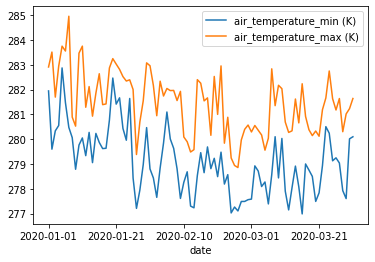

In [136]:
df[df['region_name']=='Western Isles'].plot(x='date', y=['air_temperature_min (K)','air_temperature_max (K)'])